# Data Mining. Lab #3


## Clustering

## Links

#### KL Divergence

https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction
https://en.wikipedia.org/wiki/Curse_of_dimensionality
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence

#### Autoencoders

https://habr.com/ru/post/134950/
http://ufldl.stanford.edu/wiki/index.php/Autoencoders_and_Sparsity
http://ufldl.stanford.edu/wiki/index.php/Visualizing_a_Trained_Autoencoder

https://habr.com/ru/company/antiplagiat/blog/418173/
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798
https://habr.com/ru/post/417405/
https://habr.com/ru/post/331382/

#### Books
[DATA CLUSTERING Algorithms and Applications](https://drive.google.com/drive/u/0/folders/1L8obue9R6YrYnHpxrSLlJIrGd5UmVEWL)

[Information Theory, Inference, and Learning Algorithms](https://drive.google.com/drive/u/0/folders/1L8obue9R6YrYnHpxrSLlJIrGd5UmVEWL)
 - An Example Inference Task: Clustering (page 284)

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

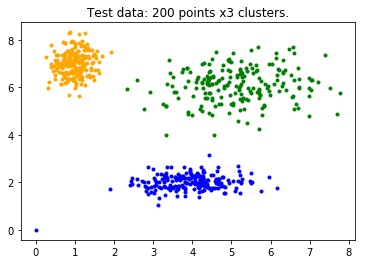

In [11]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

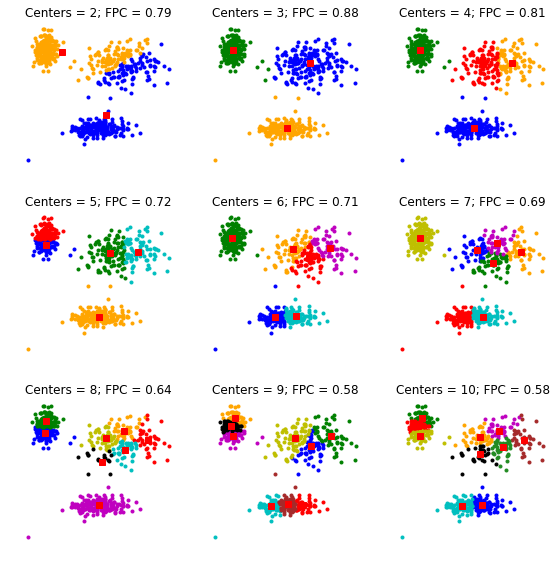

In [12]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

Text(0, 0.5, 'Fuzzy partition coefficient')

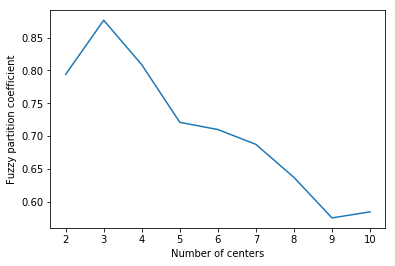

In [14]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

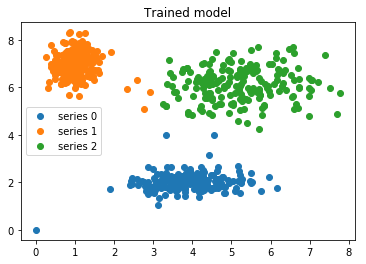

In [13]:
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

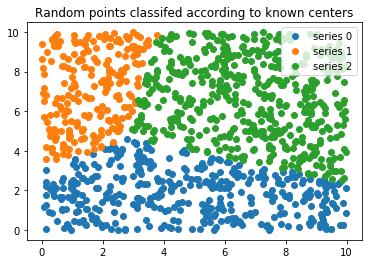

In [15]:
# Generate uniformly sampled data spread across the range [0, 10] in x and y
newdata = np.random.uniform(0, 1, (1100, 2)) * 10

# Predict new cluster membership with `cmeans_predict` as well as
# `cntr` from the 3-cluster model
u, u0, d, jm, p, fpc = fuzz.cluster.cmeans_predict(
    newdata.T, cntr, 2, error=0.005, maxiter=1000)

# Plot the classified uniform data. Note for visualization the maximum
# membership value has been taken at each point (i.e. these are hardened,
# not fuzzy results visualized) but the full fuzzy result is the output
# from cmeans_predict.
cluster_membership = np.argmax(u, axis=0)  # Hardening for visualization

fig3, ax3 = plt.subplots()
ax3.set_title('Random points classifed according to known centers')
for j in range(3):
    ax3.plot(newdata[cluster_membership == j, 0],
             newdata[cluster_membership == j, 1], 'o',
             label='series ' + str(j))
ax3.legend()

plt.show()

## t-SNE and KL divergence

## Autoencoder

## Graded Lab

### Objectives

* Unsupervised learning. [Fuzzy clustering](https://en.wikipedia.org/wiki/Fuzzy_clustering)
* [Bayesian statistics](https://en.wikipedia.org/wiki/Bayesian_statistics)
* [Nonlinear dimensionality reduction](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction)
* [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)
* [Volume of an n-ball](https://en.wikipedia.org/wiki/Volume_of_an_n-ball)
* [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
* Autoencoders
___

### Must read

* [Must read #1](http://jotterbach.github.io/2016/05/23/TSNE/)
* [Must read #2](http://jotterbach.github.io/2016/07/18/AutoEncoders/)
___

### Materials 

As your first graded lab you are offered an [Article](https://drive.google.com/open?id=1zL28yuinUcd9qHr0H-RtIw4uWNUSeov_), devoted to Deep Embedded Clustering. 

Original paper can be found [here](https://arxiv.org/pdf/1511.06335.pdf)

Code of the original paper can be found [here](https://github.com/piiswrong/dec)

All extra papers have been uploaded on [Google Drive](https://drive.google.com/drive/u/0/folders/1SrDKSSuuQSZJDKU_Al7aciSafkK0ctaX)

___

### What you have to do?

You have to implement DNN architecture proposed in an article and confirm declared results of clustering accuracy.

1. Read a paper

2. Pretrain encoder by stacked autoencoder (SAE) method proposed in a paper (section 3.2 Parameter initialization). The concept is to train full autoencoder, then extract encoder part and use it as parameterized mapping function $f_{\theta}: X \rightarrow Z$ into low-dimension embedded feature space.

3. Implement DNN architecture based on encoder, by adding clustering functional.

4. Train DNN on MNIST dataset (f 28-by-28 pixel size)

6. Calculate an clustering accuracy for three algorithms:
    * k-means
    * Encoder + k-means (first step for feature space compression, then clustering)
    * DEC

___

### Solution and Report Requirements

* You have to provide solution as ipynb file(s). In case you have to demonstrate pretrain part - it can be implemended as separate ipynb file.

* Implementation language = Python3 (3.6)

**You can use [article code](https://github.com/piiswrong/dec) as a hint, but you can not use pretrained model or its implementation.**

* You have to provide **pdf** report with answers:

1. Prove formally correctness Student’s t-distribution as a kernel to measure the similarity between embedded point $z_i$ and centroid $\mu_j$ (3.1.1 Soft Assignment, formula 1)

2. Prove formally correctness of $p_{ij}$ estimation (3.1.2 KL divergence minimization, formula 3)

3. Explain how have you implemented clusterisation part of DNN (SGD optimisation)

4. Explain how have you implemented encoder pretrain part.

5. Prove formally $O(nk)$ complexity of DEC method

** Upload ipynb files and pdf in moodle. Do not archive it before uploading.
___

### Deadline 21/02/201